In [37]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

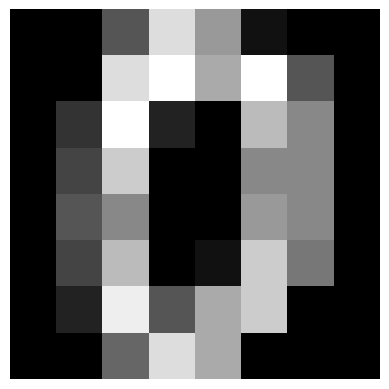

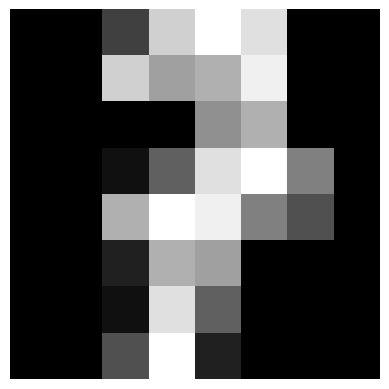

In [22]:
class MnistDataset(torch.utils.data.Dataset):
    def __init__(self, data,targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        slice_i = torch.tensor(np.take(self.data, indices=idx, axis=0), dtype=torch.float32)
        target = self.targets[idx]
        return slice_i,target

def show_bw_image(img_array):
    plt.imshow(img_array.reshape(8,8), cmap='gray')
    plt.axis('off')
    plt.show()

train_dataset = MnistDataset(load_digits().data[:1000],load_digits().target[:1000])
val_dataset = MnistDataset(load_digits().data[1000:1500],load_digits().target[1000:1500])
test_dataset = MnistDataset(load_digits().data[1500:],load_digits().target[1000:1500])
show_bw_image(train_dataset[0][0])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)
show_bw_image(next(iter(train_loader))[0][0])

input_image 6


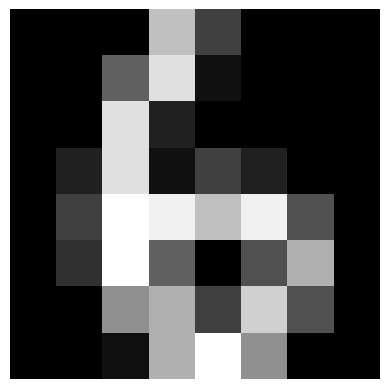

predicted_image tensor([3])


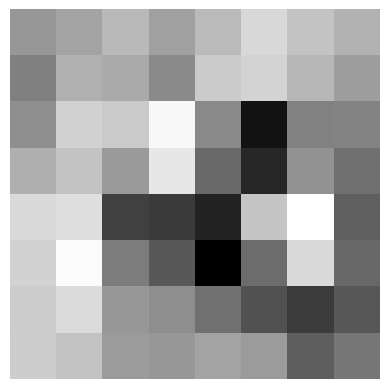

generating image for number 6


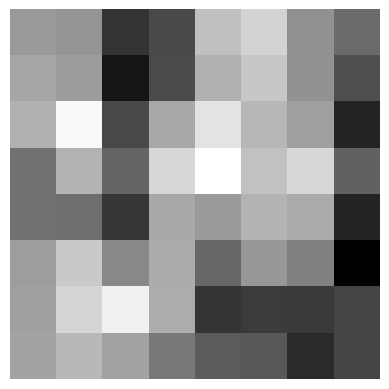

epoch 0, validation loss 51.00111381530762, train loss(53.729447479248044
epoch 1, validation loss 50.24797348022461, train loss(51.999256805419925
epoch 2, validation loss 50.07798208618164, train loss(51.623906005859375
epoch 3, validation loss 50.01511506652832, train loss(51.52378869628906
epoch 4, validation loss 49.97806800842285, train loss(51.47728662109375
epoch 5, validation loss 49.94418050384522, train loss(51.44345883178711
epoch 6, validation loss 49.91574319458008, train loss(51.41033444213867
epoch 7, validation loss 49.895663299560546, train loss(51.38575430297852
epoch 8, validation loss 49.88200273132324, train loss(51.368936096191405
epoch 9, validation loss 49.871906326293946, train loss(51.357006896972656
epoch 10, validation loss 49.86560063934326, train loss(51.34853173828125
epoch 11, validation loss 49.86121446990967, train loss(51.34309219360352
epoch 12, validation loss 49.858304252624514, train loss(51.33938983154297
epoch 13, validation loss 49.85625900268

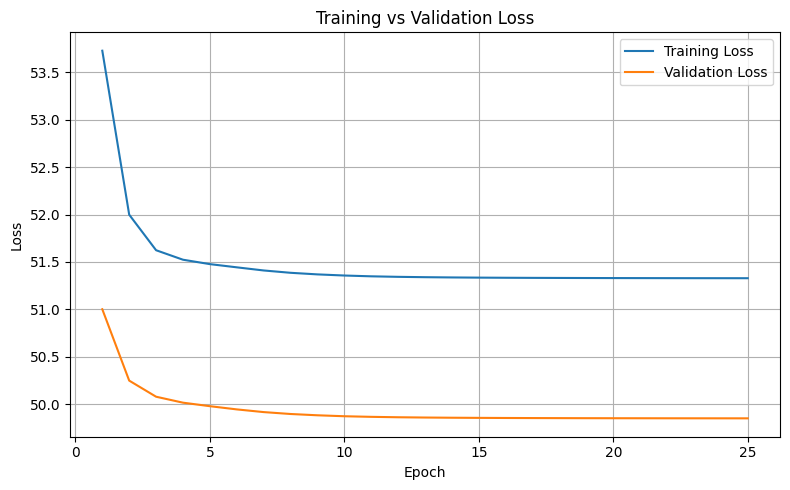

input_image 1


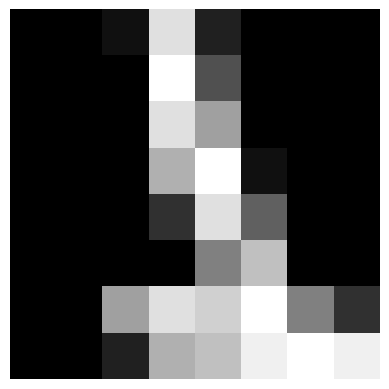

predicted_image tensor([4])


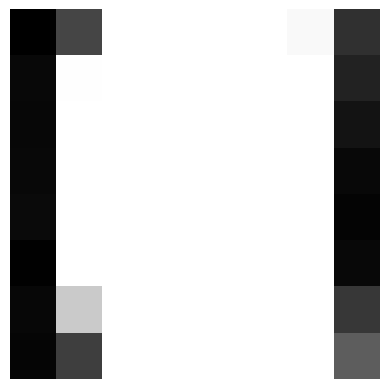

generating image for number 6


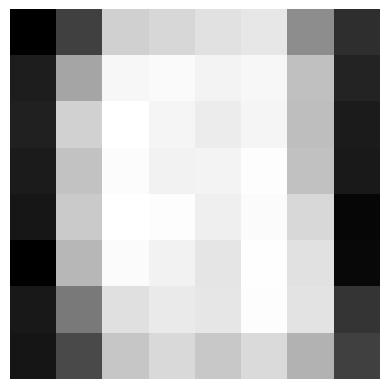

In [96]:
class simple_autoencoder(torch.nn.Module):
    def __init__(self):
        super(simple_autoencoder, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 3, stride=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1)

        self.fc1 = nn.Linear(64, 10)
        self.fc2 = nn.Linear(10, 64)

        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1)
        self.deconv2 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.maxPool = nn.MaxPool2d(2, 2)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def encoder(self,input):
        # print("shape 1",input.shape)
        x = input.view(-1,1,8,8)
        # print("shape 2",x.shape)
        x = self.relu(self.conv1(x))# we started with an (n,1,8,8) image, then get (n,32,6,6)
        # print("shape 3",x.shape)
        x = self.maxPool(x)# we start with (n,32,6,6) then we get (n,32,3,3)
        # print("shape 4",x.shape)
        x = self.relu(self.conv2(x))# from (n,32,3,3) we then get (n,64,1,1)
        # print("shape 5",x.shape)
        x = x.view(-1,64)# now at (n,64)
        # print("shape 6",x.shape)
        latent = self.sigmoid(self.fc1(x))# now at (n,10)
        # print("shape 7",x.shape)
        return latent

    def decoder(self, latent):
        x = self.fc2(latent)# now at (n,64), note for the GPT, do I need a relu function here?
        # print("shape -1",x.shape)
        x = x.view(-1,64,1,1)# now at (n,64,1,1) Confirmed but the deconv gives me an error
        # print("shape -2",x.shape)
        x = self.relu(self.deconv1(x))# now at (n,32,3,3)
        # print("shape -3",x.shape)
        x = self.upsample(x)# now at (n,32,6,6)
        # print("shape -4",x.shape)
        x = self.sigmoid(self.deconv2(x))#now at (n,1,8,8)
        # print("shape -5",x.shape)
        x = x.view(-1,64)
        # print("shape -6",x.shape)
        # print("x",x.shape,x)
        return x

    def forward(self, input):
        
        latent = self.encoder(input)
        x = self.decoder(latent)

        return x,latent

    def generate_image_from_one_hot(self,latent):
        return self.decoder(latent)

def visualise_prediction(model, batch,index = 0):
    data,label = batch
    raw_input = np.take(data, indices=index, axis=0)
    # print("raw_input",raw_input.shape,raw_input)
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient tracking for efficiency
        # input = torch.tensor(np.expand_dims(raw_input, axis=0), dtype=torch.float32)
        input = data
        # print("input",input.shape,input)
        predicted_output,pred_label = model(input)
        pred_label = pred_label.argmax(dim=1)
        predicted_output = predicted_output.numpy()[0]
        # print("pred",predicted_output.shape,predicted_output)
        print("input_image", label)
        show_bw_image(input)

        print("predicted_image", pred_label)
        show_bw_image(predicted_output)

def generate_image_from_one_hot(model, number = None,one_hot = None):
    if number:
            print(f"generating image for number {number}")
            one_hot = [0] * 10
            one_hot[number] = 1
    one_hot = torch.tensor(one_hot, dtype=torch.float32)
    # print("onehot",type(one_hot),one_hot.shape)
    model.eval()
    with torch.no_grad():
        predicted_output = model.generate_image_from_one_hot(one_hot)
        predicted_output = predicted_output.numpy()[0]
        show_bw_image(predicted_output)
        
def plot_losses(val_losses,train_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
def Validate(model, val_loader):
    MSE_loss = nn.MSELoss()
    CE_loss = nn.CrossEntropyLoss()
    model.eval()
    losses = []
    with torch.no_grad():
        for batch in val_loader:
            input,target = batch
            target = F.one_hot(target, num_classes=10).float()
            output, latent = model(input)
    
            mse_loss = MSE_loss(output, input)
            ce_loss = CE_loss(latent, target)
            loss = mse_loss
            losses.append(loss.item())
    return np.mean(losses)
    
def Train(model,train_loader, val_loader, epochs,lr):
    MSE_loss = nn.MSELoss()
    CE_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    gradients = []
    epoch_val_losses = []
    epoch_train_losses = []

    for epoch in range(epochs):
        model.train()
        losses = []
        for batch in train_loader:
            input,target = batch
            target = F.one_hot(target, num_classes=10).float()
            # print("input",input.shape)
            # print("target", target.shape)
            optimizer.zero_grad() #sets initial gradients to 0 for security purposes
        
            output, latent = model(input)
            # print("latent",latent,"target",target)
            mse_loss = MSE_loss(output, input)
            # ce_loss = CE_loss(latent, target)
            loss = mse_loss
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
        epoch_val_losses.append(Validate(model, val_loader))
        epoch_train_losses.append(np.mean(losses))
        # print('epoch {}, loss {}'.format(epoch, loss.item()))
        print(f'epoch {epoch}, validation loss {epoch_val_losses[-1]}, train loss({epoch_train_losses[-1]}')

    plot_losses(epoch_val_losses,epoch_train_losses)  


    
learning_rate = 0.0001
num_epochs = 25

model = simple_autoencoder()
visualise_prediction(model,val_dataset[random.randrange(10)])
generate_image_from_one_hot(model,number = 6)
Train(model,train_loader, val_loader, num_epochs,learning_rate)
visualise_prediction(model,val_dataset[random.randrange(10)])
generate_image_from_one_hot(model,number = 6)


input_image 2


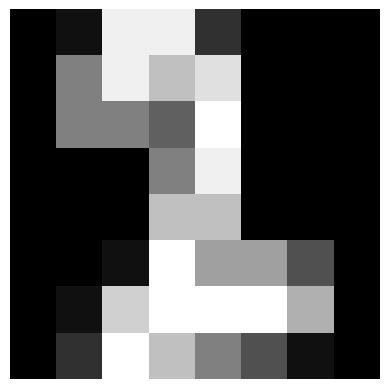

predicted_image tensor([4])


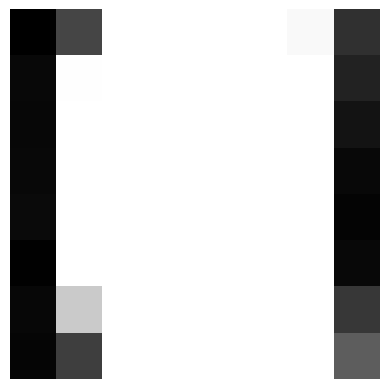

input_image 2


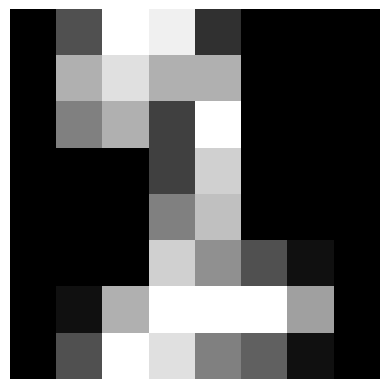

predicted_image tensor([4])


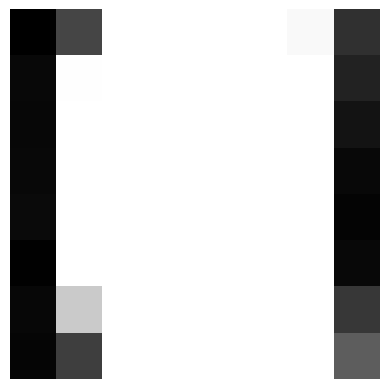

input_image 9


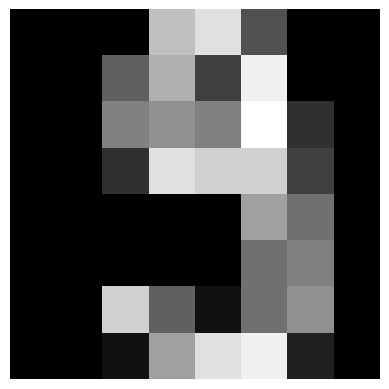

predicted_image tensor([4])


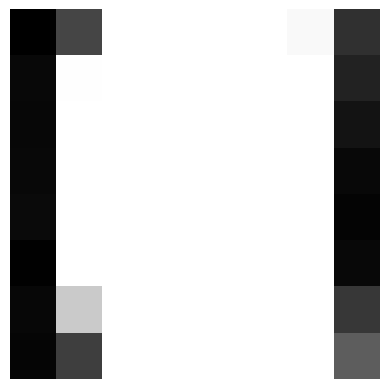

input_image 3


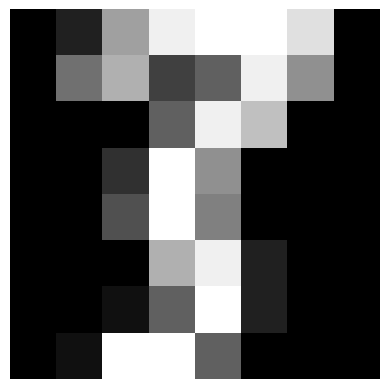

predicted_image tensor([4])


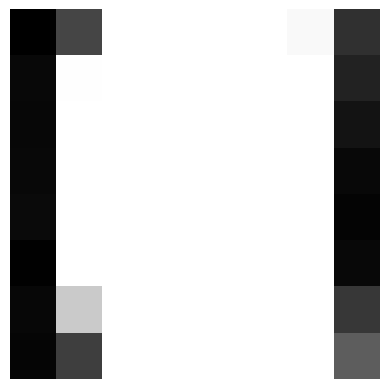

input_image 0


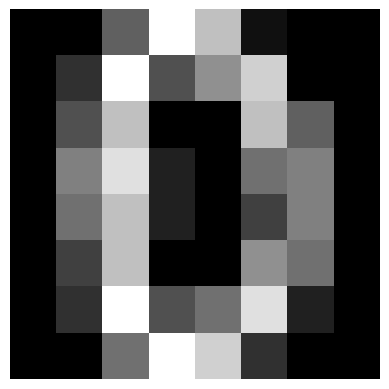

predicted_image tensor([4])


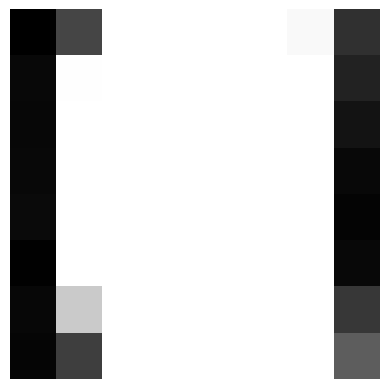

input_image 2


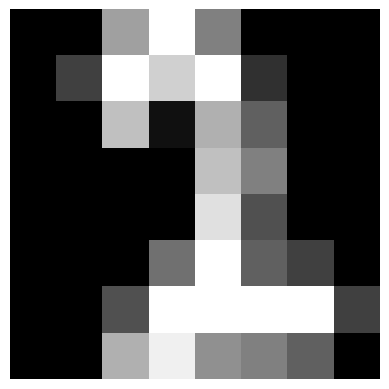

predicted_image tensor([4])


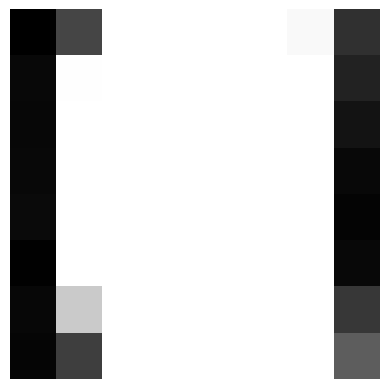

input_image 7


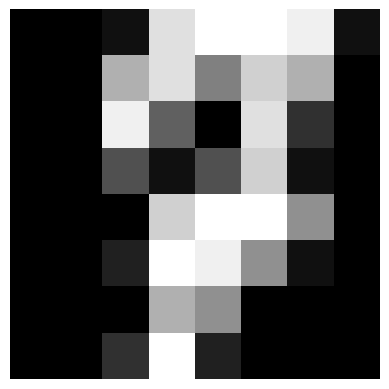

predicted_image tensor([4])


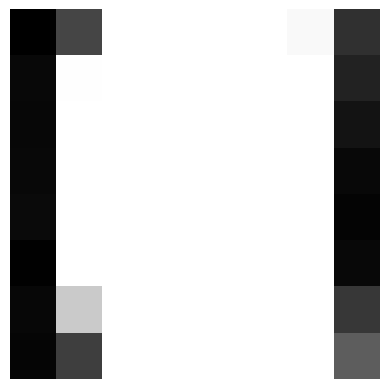

input_image 6


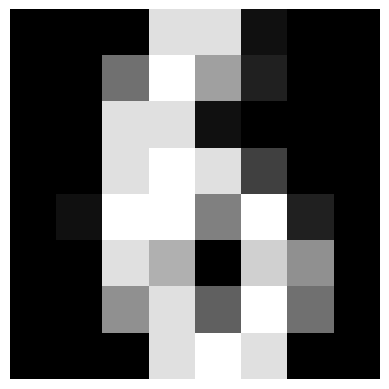

predicted_image tensor([4])


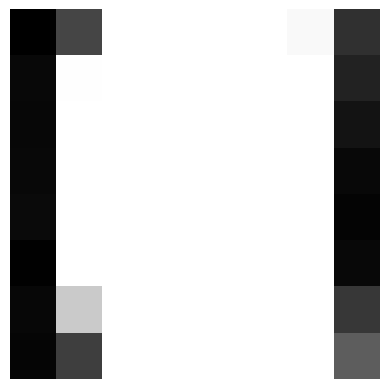

input_image 8


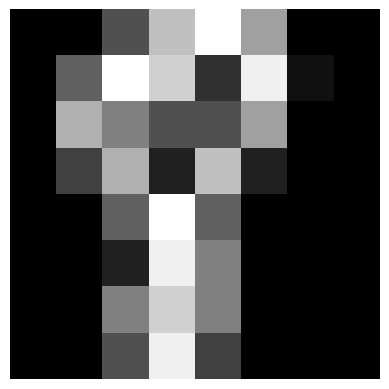

predicted_image tensor([4])


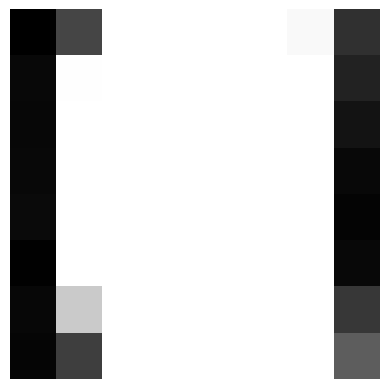

input_image 6


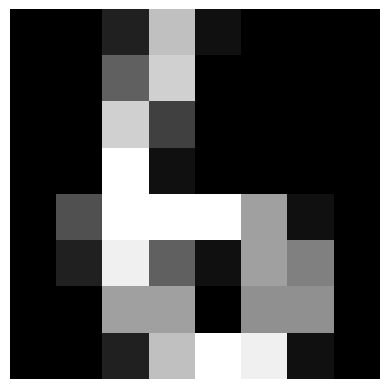

predicted_image tensor([4])


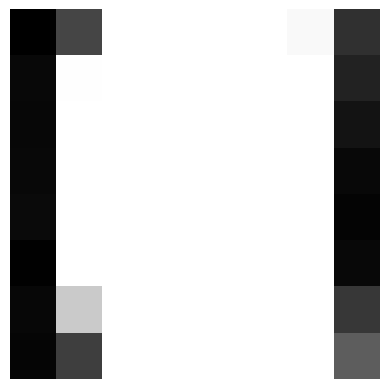

In [97]:
import random

indices = random.sample(range(len(val_dataset)), 10)
for i in indices:
    # print(i)
    # print(val_dataset[i])
    visualise_prediction(model, val_dataset[i])

generating image for number 9


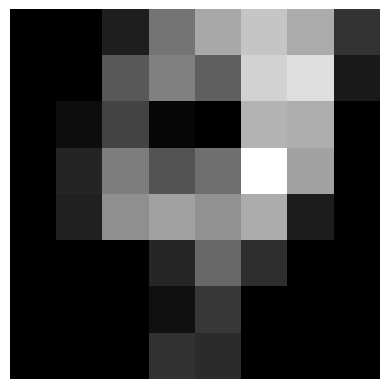

In [89]:
generate_image_from_one_hot(model,number =9)
